In [138]:
# %pip install -U gymnasium
# %pip install -U gymnasium[classic-control]

In [139]:
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import gymnasium as gym
import matplotlib.pyplot as plt
from IPython import display
import ipywidgets as widgets
from IPython.display import clear_output
import numpy as np

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [187]:
LR = 3e-4
GAMMA = 0.9
MAX_STEPS = 1000
N_HIDDEN = 32
EPS = torch.finfo(torch.float32).eps
ENTROPY_REGULARIZATION = 0.001

In [141]:
env = gym.make('CartPole-v1', render_mode='rgb_array')

## utils

In [142]:
def plot_score(scores, validations=None, window=50, validation_rate=100):
    averages = []
    running_sum = sum(scores[:window])
    for i in range(window, len(scores)):
        running_sum += scores[i] - scores[i - window]
        averages.append(running_sum / window)
    plt.plot(scores, label='score')
    plt.plot(averages, label=f'windowed average ({window})')
    if validations:
        x = torch.arange(len(validations)) * validation_rate
        plt.plot(x, validations, label='validation')
    plt.legend()
    plt.show()

In [143]:
@torch.no_grad()
def validation(env, policy, max_steps=MAX_STEPS, epochs=5):
    scores = []
    for _ in range(epochs):
        state, _ = env.reset()
        for t in range(max_steps):
            action = policy(torch.tensor(state).to(device)).argmax().item()
            state, _, done, _, _ = env.step(action)
            if done:
                break
        scores.append(t)
    return sum(scores) / len(scores)

In [144]:
@torch.no_grad()
def show_play(env, policy, max_steps=MAX_STEPS):
    fig, ax = plt.subplots(figsize=(5, 4))
    ax.axis('off')
    state, _ = env.reset()
    img = ax.imshow(env.render())
    for t in range(max_steps):
        actions = policy(torch.tensor(state).float().to(device))
        action = actions.argmax()
        state, _, done, _, _ = env.step(action.item())
        img.set_data(env.render())
        display.display(plt.gcf())
        display.clear_output(wait=True)
        if done:
            print("Episode finished after {} timesteps".format(t + 1))
            break

In [145]:
def discount_rewards(rewards, gamma):
    '''
    Compute the discounted rewards backwards through time, e.g.
      r0 + gamma * (r1 + gamma * (r2 + gamma * (...)))
      [----------------------------------------------]
         ^         [---------------------------------]
         |           ^           [-------------------]
      discount[0]    |             ^           [-----]
                  discount[1]      |             ^
                                discount[2]      |
                                              discount[n]                                              
    '''
    reward = 0
    discounted_rewards = []
    for r in rewards[::-1]:
        reward = r + gamma * reward
        discounted_rewards.append(reward)
    return torch.tensor(discounted_rewards[::-1]).to(device)

## REINFORCE

REINFORCE → REward Increment = Nonnegative Factor x Offset Reinforcement x Characteristic Eligibility

In [146]:
class ReinforcePolicy(nn.Module):
    def __init__(self, n_in, n_out, n_hidden=N_HIDDEN):
        super().__init__()
        self.f = nn.Sequential(
            nn.Linear(n_in, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_out),
            nn.Softmax(dim=-1)
        )

    def forward(self, x):
        return self.f(x)

In [192]:
r_policy = ReinforcePolicy(n_in=4, n_out=2).to(device)
r_scores = []
r_validations = []

### train

0     loss=  -2.30 explore=41.03 % score=   39 validation=672
100   loss=   0.90 explore=35.59 % score=   59 validation=731
200   loss=   1.75 explore=57.14 % score=   14 validation=198
300   loss=  -5.78 explore=36.84 % score=   57 validation=511
400   loss=  -0.54 explore=46.15 % score=   26 validation=380
500   loss=  -0.32 explore=37.50 % score=   72 validation=695
600   loss=  -6.04 explore=24.83 % score=  145 validation=892
700   loss=   0.54 explore=34.51 % score=  113 validation=895
800   loss=   0.07 explore=42.42 % score=   33 validation=757
900   loss=   0.80 explore=34.43 % score=  183 validation=999


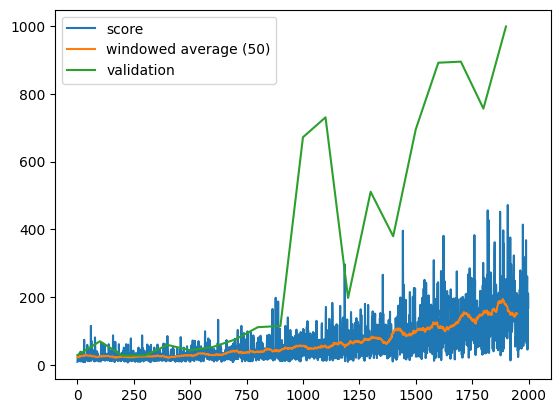

In [186]:
def train(model, epochs=10, lr=LR, gamma=GAMMA, max_steps=MAX_STEPS, log_every=100, scores=r_scores, entropy_regularization=ENTROPY_REGULARIZATION):
    model = model.to(device)
    model.train()
    opt = optim.Adam(model.parameters(), lr=lr)
    for epoch in range(epochs):
        rewards, log_probs, entropies = [], [], []
        explored = 0
        state, _ = env.reset()
        # forward
        for t in range(max_steps):
            # this feel bad performance wise, 1 cycle GPU, 1 cycle CPU
            # it's too much context switching
            # how can I benchmark this in a notebook?
            actions = model(torch.tensor(state).to(device))
            action = torch.multinomial(actions, 1)
            explored += action != actions.argmax()
            state, reward, done, _, _ = env.step(action.item())
            rewards.append(reward)
            log_probs.append(actions[action].log())
            entropies.append(-(actions * torch.log(actions)).sum()) # prey for no NaNs (otherwise add a + EPS)
            if done:
                break
        # backward
        losses = []
        discounted_rewards = discount_rewards(rewards, gamma)
        normalized_discounted_rewards = (discounted_rewards - discounted_rewards.mean()) / (discounted_rewards.std() + EPS)
        for log_prob, reward in zip(log_probs, normalized_discounted_rewards):
            losses.append(-log_prob * reward)
        entropy_loss = - torch.stack(entropies).sum() # negative because we want to increase entropy
        loss = torch.stack(losses).sum() + entropy_regularization * entropy_loss
        opt.zero_grad()
        loss.backward()
        opt.step()
        if epoch % log_every == 0:
            validation_score = validation(env, model)
            r_validations.append(validation_score)
            print(f'{epoch:<5} loss={loss.item():>7.2f} explore={100 * explored.item() / t:>5.2f} % score={t:>5} validation={validation_score:.0f}')

        scores.append(t)
    model.eval()

train(r_policy, epochs=1000)
plot_score(r_scores, r_validations)

In [190]:
# save
# ----
# torch.save(r_policy.state_dict(), 'weights/cartpole-reinforce.pt')

# load
# ----
# m = ReinforcePolicy(n_in=4, n_out=2).to(device)
# m.load_state_dict(torch.load('weights/cartpole-reinforce.pt'))

### play

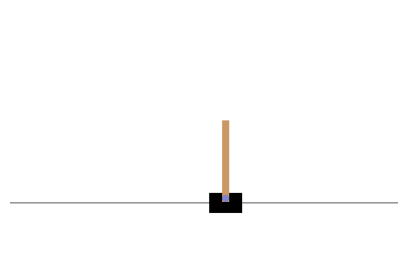

In [189]:
show_play(env, r_policy)

### profiling

In [151]:
# split the code in a bunch of functions to make the cProfile easier to read

def gpu_world(model, arg):
    return model(arg)

def cpu_world_simulate_env(env, action):
    return env.step(action.item())

def cpu_world_get_action(actions, log_probs):
    # Categorical seems dog slow
    # --------------------------
    # m = torch.distributions.Categorical(actions)
    # action = m.sample()
    # log_probs.append(m.log_prob(action))

    # multinormal is faster
    # ---------------------
    action = torch.multinomial(actions, 1)
    log_probs.append(torch.log(actions[action]))

    # but they should be equivalent
    # -----------------------------
    # assert m.log_prob(action) - torch.log(actions[action]) < 0.001

    return action

def cpu_world_sample(rewards, log_probs, env, actions):
    action = cpu_world_get_action(actions, log_probs)

    state, reward, done, _, _ = cpu_world_simulate_env(env, action)
    rewards.append(reward)
    return state, done

def cpu_world_backward_pass(rewards, log_probs, gamma):
    losses = []
    discounted_rewards = discount_rewards(rewards, gamma)
    normalized_discounted_rewards = (discounted_rewards - discounted_rewards.mean()) / (discounted_rewards.std() + EPS)
    for log_prob, reward in zip(log_probs, normalized_discounted_rewards):
        losses.append(-log_prob * reward)
    return losses

def gpu_world_backward_pass(losses, opt):
    loss = torch.stack(losses).to(device).sum()
    opt.zero_grad()
    loss.backward()
    opt.step()
    return loss

def train_for_profiling(model, epochs=100, lr=LR, gamma=GAMMA, max_steps=MAX_STEPS):
    model = model.to(device)
    model.train()
    opt = optim.Adam(model.parameters(), lr=lr)
    for epoch in range(epochs):
        rewards, log_probs = [], []
        state, _ = env.reset()
        # forward pass
        for _ in range(max_steps):
            actions = gpu_world(model, torch.tensor(state).float().to(device))
            state, done = cpu_world_sample(rewards, log_probs, env, actions)
            if done: break
        # backward pass
        losses = cpu_world_backward_pass(rewards, log_probs, gamma)
        loss = gpu_world_backward_pass(losses, opt)
        if epoch % 10 == 0:
            print(f'{epoch:5} {loss.item()}')

In [152]:
import cProfile
import pstats
import io

def profile_train(model):
    pr = cProfile.Profile()
    pr.enable()
    train_for_profiling(model)
    pr.disable()
    s = io.StringIO()
    ps = pstats.Stats(pr, stream=s).sort_stats('cumulative')
    ps.print_stats()
    return s.getvalue()

profile_output = profile_train(r_policy)
print(profile_output)

    0 -3.506568670272827
   10 -0.1585693359375
   20 0.31032800674438477
   30 0.8864667415618896
   40 1.2831541299819946
   50 0.7466640472412109
   60 0.7476024627685547
   70 0.15681791305541992
   80 1.466324806213379
   90 -2.0493550300598145
         267342 function calls (246101 primitive calls) in 5.952 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.069    0.069    5.952    5.952 C:\Users\p\AppData\Local\Temp\ipykernel_33816\2794650987.py:49(train_for_profiling)
     4240    0.009    0.000    2.190    0.001 C:\Users\p\AppData\Local\Temp\ipykernel_33816\2794650987.py:27(cpu_world_sample)
      100    0.001    0.000    2.047    0.020 C:\Users\p\AppData\Local\Temp\ipykernel_33816\2794650987.py:42(gpu_world_backward_pass)
      100    0.001    0.000    1.971    0.020 c:\Users\p\Desktop\_ML\huggingface-nlp-course\venv\Lib\site-packages\torch\_tensor.py:428(backward)
      100    0.001    0.000    1.97

## REINFORCE with Baseline


We introduce a `Value` net in the hope to reduce the variance (converge faster). So it's not a pure policy technique anymore.

Advantage = discounted_reward - predicted_value

In [154]:
class ReinforceBaselinePolicy(nn.Module):
    def __init__(self, n_in, n_out, n_hidden=N_HIDDEN):
        super().__init__()
        self.f = nn.Sequential(
            nn.Linear(n_in, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_out),
            nn.Softmax(dim=-1)
        )

    def forward(self, x):
        return self.f(x)
    
class ReinforceBaselineValue(nn.Module):
    def __init__(self, n_in, n_hidden=N_HIDDEN):
        super().__init__()
        self.f = nn.Sequential(
            nn.Linear(n_in, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, 1)
        )

    def forward(self, x):
        return self.f(x)

In [193]:
rb_policy = ReinforceBaselinePolicy(n_in=4, n_out=2).to(device)
rb_value = ReinforceBaselineValue(n_in=4).to(device)
rb_scores = []
rb_validations = []

### train

0     loss=  68.00 explore=29.23 % score=  130 validation=561
100   loss= 148.17 explore=34.38 % score=  192 validation=762
200   loss=  -1.86 explore=29.90 % score=   97 validation=797
300   loss=  -9.79 explore=33.04 % score=  112 validation=913
400   loss=   1.12 explore=36.84 % score=   76 validation=854
500   loss= -44.85 explore=34.29 % score=   35 validation=643
600   loss= -30.39 explore=35.38 % score=  130 validation=845
700   loss=  30.49 explore=28.88 % score=  187 validation=703
800   loss=  65.31 explore=30.08 % score=  246 validation=987
900   loss=  96.32 explore=32.64 % score=  337 validation=861


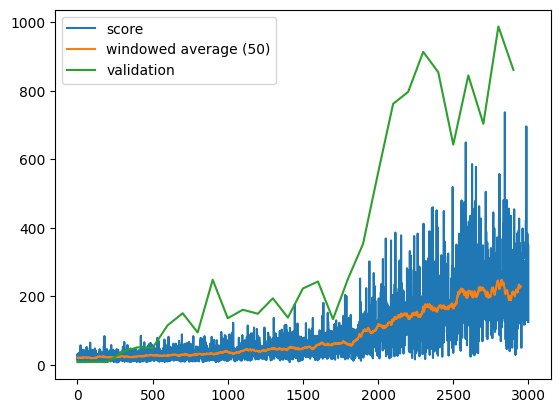

In [196]:
def rb_train(policy, value, epochs=10, lr=LR, gamma=GAMMA, max_steps=MAX_STEPS, log_every=100, scores=rb_scores, entropy_regularization=ENTROPY_REGULARIZATION):
    policy = policy.to(device)
    value = value.to(device)
    policy.train()
    value.train()
    opt_p = optim.Adam(policy.parameters(), lr=lr)
    opt_v = optim.Adam(value.parameters(), lr=lr)
    for epoch in range(epochs):
        rewards, log_probs, values, entropies = [], [], [], []
        state, _ = env.reset()
        explored = 0
        # forward
        for t in range(max_steps):
            state = torch.tensor(state).float().to(device)
            values.append(value(state))
            actions = policy(state)
            action = torch.multinomial(actions, 1)
            explored += action != actions.argmax()
            state, reward, done, _, _ = env.step(action.item())
            rewards.append(reward)
            log_probs.append(torch.log(actions[action]))
            entropies.append(-(actions * torch.log(actions)).sum()) # prey for no NaNs (otherwise add a + EPS)
            if done:
                break
        
        # backward
        values = torch.cat(values)
        discounted_rewards = discount_rewards(rewards, gamma)
        # backward value
        loss = F.mse_loss(values, discounted_rewards)
        opt_v.zero_grad()
        loss.backward(retain_graph=True)
        opt_v.step()
        # backward policy
        losses = []
        advantages = discounted_rewards - values
        for log_prob, advantage in zip(log_probs, advantages):
            losses.append(-log_prob * advantage)
        entropy_loss = - torch.stack(entropies).sum() # negative because we want to increase entropy
        loss = torch.stack(losses).sum() + entropy_regularization * entropy_loss
        opt_p.zero_grad()
        loss.backward()
        opt_p.step()

        if epoch % log_every == 0:
            validation_score = validation(env, policy)
            rb_validations.append(validation_score)
            print(f'{epoch:<5} loss={loss.item():>7.2f} explore={100 * explored.item() / t:>5.2f} % score={t:>5} validation={validation_score:.0f}')
        scores.append(t)
    policy.eval()
    value.eval()

rb_train(rb_policy, rb_value, epochs=1000)
plot_score(rb_scores, rb_validations)

In [197]:
# save
# ----
# torch.save(rb_policy.state_dict(), 'weights/rb_policy-cartpole.pt')
# torch.save(rb_value.state_dict(), 'weights/rb_value-cartpole.pt')

# load
# ----
# mp = ReinforceBaselinePolicy(n_in=4, n_out=2).to(device)
# mp.load_state_dict(torch.load('weights/rb_policy-cartpole.pt'))
# mv = ReinforceBaselineValue(n_in=4).to(device)
# mv.load_state_dict(torch.load('weights/rb_value-cartpole.pt'))

### play

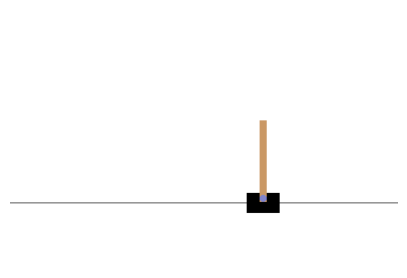

In [198]:
show_play(env, rb_policy)

## Actor Critic

Similar to REINFORCE with Baseline but include TD (Temporal Difference) method so we are more sample efficient (aka. we can train on individual steps instead of entire episodes).

In [ ]:
class Actor(nn.Module):
    def __init__(self, n_in, n_out, n_hidden=N_HIDDEN):
        super().__init__()
        self.f = nn.Sequential(
            nn.Linear(n_in, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_out),
            nn.Softmax(dim=-1)
        )

    def forward(self, x):
        return self.f(x)
    
class Critic(nn.Module):
    def __init__(self, n_in, n_hidden=N_HIDDEN):
        super().__init__()
        self.f = nn.Sequential(
            nn.Linear(n_in, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, 1)
        )

    def forward(self, x):
        return self.f(x)

In [ ]:
ac_actor = Actor(n_in=4, n_out=2).to(device)
ac_critic = Critic(n_in=4).to(device)
ac_scores = []

### train

In [ ]:
def ac_train(actor, critic, epochs=10, lr=LR, gamma=GAMMA, max_steps=MAX_STEPS, log_every=100, scores=ac_scores):
    policy = policy.to(device)
    value = value.to(device)
    policy.train()
    value.train()
    opt_p = optim.Adam(policy.parameters(), lr=lr)
    opt_v = optim.Adam(value.parameters(), lr=lr)
    for epoch in range(epochs):
        rewards, log_probs, values = [], [], []
        state, _ = env.reset()
        # forward
        for t in range(max_steps):
            state = torch.tensor(state).to(device)
            values.append(value(state))
            actions = policy(state)
            action = torch.multinomial(actions, 1)
            state, reward, done, _, _ = env.step(action.item())
            rewards.append(reward)
            log_probs.append(torch.log(actions[action]))
            if done:
                break
        
        # backward
        values = torch.cat(values)
        discounted_rewards = discount_rewards(rewards, gamma)
        # backward value
        loss = F.mse_loss(values, discounted_rewards)
        opt_v.zero_grad()
        loss.backward(retain_graph=True)
        opt_v.step()
        # backward policy
        losses = []
        advantages = discounted_rewards - values
        for log_prob, advantage in zip(log_probs, advantages):
            losses.append(-log_prob * advantage)
        loss = torch.stack(losses).sum()
        opt_p.zero_grad()
        loss.backward()
        opt_p.step()

        if epoch % log_every == 0:
            print(f'{epoch:5}\t loss: {loss.item()}\t episode length: {t}')
        scores.append(t)
    policy.eval()
    value.eval()

ac_train(ac_actor, ac_critic, epochs=1000)
plot_score(ac_scores)

In [ ]:
# save
# ----
# torch.save(actor.state_dict(), 'weights/ac_actor-cartpole.pt')
# torch.save(critic.state_dict(), 'weights/ac_critic-cartpole.pt')

# load
# ----
# ac_a = Actor(n_in=4, n_out=2).to(device)
# ac_a.load_state_dict(torch.load('weights/ac_actor-cartpole.pt'))
# ac_c = Critic(n_in=4).to(device)
# ac_c.load_state_dict(torch.load('weights/ac_critic-cartpole.pt'))

### play

## A2C (Advantage Actor Critic)

In [ ]:
class Actor(nn.Module):
    def __init__(self, n_in, n_out, n_hidden=10):
        super().__init__()
        self.f = nn.Sequential(
            nn.Linear(n_in, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_out),
            nn.Softmax(dim=-1)
        )

    def forward(self, x):
        return self.f(x)

class Critic(nn.Module):
    def __init__(self, n_in, n_hidden=10):
        super().__init__()
        self.f = nn.Sequential(
            nn.Linear(n_in, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, 1)
        )

    def forward(self, x):
        return self.f(x)

actor = Actor(n_in=10, n_out=2)
critic = Critic(n_in=10)

In [ ]:
def train(epochs=100, lr=LR):
    actor_opt = optim.Adam(actor.parameters(), lr=lr)
    critic_opt = optim.Adam(critic.parameters(), lr=lr)

    for epoch in range(epochs):
        state = env.reset()
        done = False

        while not done:
            action_probs = actor(torch.from_numpy(state).float())
            action = torch.multinomial(action_probs, 1).item()

            next_state, reward, done, _ = env.step(action)

            V_current = critic(torch.from_numpy(state).float())
            V_next = critic(torch.from_numpy(next_state).float())

            # Compute advantage and TD-target
            advantage = reward + (1 - int(done)) * V_next - V_current
            td_target = reward + (1 - int(done)) * V_next

            # Update the critic
            critic_loss = advantage.pow(2)
            critic_opt.zero_grad()
            critic_loss.backward()
            critic_opt.step()

            # Update the actor
            actor_loss = -torch.log(action_probs[action]) * advantage.detach()
            actor_opt.zero_grad()
            actor_loss.backward()
            actor_opt.step()

            state = next_state

# PPO

$L^{CPI}(\theta) = \mathbb{E}_t [ \frac{\pi_\theta(a_t | s_t)}{\pi_{{\theta}_{old}(a_t | s_t)}} A_t] = \mathbb{E}_t [r_t(\theta)A_t]$

$L^{CLIP}(\theta) = \mathbb{E}_t [min(r_t(\theta)A_t, clip(r_t(\theta), 1 - \epsilon, 1 + \epsilon) A_t)]$


- $\mathbb{E}$ : expected value
- $A$: advantage